In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import itertools
import math

In [2]:
with open("demonslayer.txt", "r", encoding="utf-8") as f:
    text = f.read()

words = text.split()

# build vocab
vocab = sorted(set(words))
vocab_size = len(vocab)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

data = [word_to_idx[word] for word in words]

print(f"Dataset size: {len(data)} words")
print(f"Vocabulary size: {vocab_size} unique words")

Dataset size: 3795 words
Vocabulary size: 1523 unique words



Create dataset for word-level sequences

In [3]:
from torch.utils.data import Dataset, DataLoader

class WordDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data  # data is a list of word indices
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx + 1:idx + self.seq_len + 1], dtype=torch.long)
        return x, y
    
    
# Split data into 80% train, 10% validation, 10% test
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x
    
    
class TransformerLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size)
        encoder_layer = nn.TransformerEncoderLayer (d_model=embed_size,                                nhead=num_heads,
          dim_feedforward=hidden_size,
          dropout=dropout,
          batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, x, src_mask=None):
        x = self.embedding(x) * math.sqrt(x.size(-1))  # scale embeddings
        x = self.pos_encoder(x)
        output = self.transformer(x, src_key_padding_mask=None, mask=src_mask)
        output = self.fc(output)
        return output


helper functions

In [5]:
def evaluate_validation(model, val_loader, criterion):
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            output = model(x_batch)
            loss = criterion(output.view(-1, vocab_size), y_batch.view(-1))
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_perplexity = math.exp(avg_val_loss)
    return avg_val_loss, val_perplexity


def evaluate_test(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            output = model(x_batch)
            loss = criterion(output.view(-1, vocab_size), y_batch.view(-1))
            total_loss += loss.item()
    avg_test_loss = total_loss / len(test_loader)
    test_perplexity = math.exp(avg_test_loss)
    return avg_test_loss, test_perplexity


def generate_text(model, start_text, max_len=200, temperatures=[0.7,1.0,1.3]):
    model.eval()
    start_words = start_text.split()
    input_ids = torch.tensor([[word_to_idx.get(word, 0) for word in start_words]], dtype=torch.long)
    
    results = {}
    for temp in temperatures:
        generated_words = start_words.copy()
        for _ in range(max_len):
            output = model(input_ids)
            output = output[:, -1, :]  # last token logits
            probabilities = F.softmax(output / temp, dim=-1)
            next_word_id = torch.multinomial(probabilities, num_samples=1).item()
            next_word = idx_to_word[next_word_id]
            generated_words.append(next_word)
            input_ids = torch.cat([input_ids, torch.tensor([[next_word_id]])], dim=1)
        results[temp] = ' '.join(generated_words)
    return results

In [6]:
def run_group_transformer(group_name, dropout_val, seq_len_val, train_data, val_data, test_data,
                          num_epochs=5, batch_size=64):
    # Prepare datasets
    train_dataset = WordDataset(train_data, seq_len_val)
    val_dataset = WordDataset(val_data, seq_len_val)
    test_dataset = WordDataset(test_data, seq_len_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Hyperparameter search
    results = []
    for num_layers, embed_size, hidden_size, num_heads, lr in itertools.product(
            [2,4], [64,128], [128,256], [2,4], [0.001, 0.0005]):
        
        model = TransformerLanguageModel(vocab_size, embed_size, num_heads, hidden_size, num_layers, dropout=dropout_val)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(num_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                optimizer.zero_grad()
                output = model(x_batch)
                loss = criterion(output.view(-1, vocab_size), y_batch.view(-1))
                loss.backward()
                optimizer.step()

        val_loss, val_ppl = evaluate_validation(model, val_loader, criterion)
        results.append({
            'num_layers': num_layers,
            'embed_size': embed_size,
            'hidden_size': hidden_size,
            'num_heads': num_heads,
            'learning_rate': lr,
            'dropout': dropout_val,
            'val_loss': val_loss,
            'val_ppl': val_ppl
        })

    best = min(results, key=lambda x: x['val_loss'])
    print(f"\n{group_name} - Best hyperparameters: {best}")


    # Train final model with best hyperparameters
    embed_size = best['embed_size']
    hidden_size = best['hidden_size']
    num_layers = best['num_layers']
    num_heads = best['num_heads']
    learning_rate = best['learning_rate']

    model = TransformerLanguageModel(vocab_size, embed_size, num_heads, hidden_size, num_layers, dropout=dropout_val)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output.view(-1, vocab_size), y_batch.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        val_loss, _ = evaluate_validation(model, val_loader, criterion)
        val_losses.append(val_loss)

    elapsed_time = time.time() - start_time
    print(f"{group_name} - Training time: {elapsed_time:.2f} seconds")


    # Final validation perplexity and loss 
    final_val_loss, final_val_ppl = evaluate_validation(model, val_loader, criterion)
    print(f"{group_name} - Final Validation Loss: {final_val_loss:.4f}, Validation Perplexity: {final_val_ppl:.2f}")

    # Plot training and validation loss
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{group_name} - Training & Validation Loss")
    plt.legend()
    plt.show()

    # Test set evaluation
    test_loss, test_ppl = evaluate_test(model, test_loader, criterion)
    print(f"{group_name} - Test Loss: {test_loss:.4f}, Test Perplexity: {test_ppl:.2f}")

    # Generate text
    start_text = "Demon Slayer"
    generated_texts = generate_text(model, start_text)
    for temp, text in generated_texts.items():
        print(f"\n{group_name} - Temperature {temp}:\n{text}\n")


Group D - Best hyperparameters: {'num_layers': 4, 'embed_size': 64, 'hidden_size': 256, 'num_heads': 4, 'learning_rate': 0.0005, 'dropout': 0.2, 'val_loss': 7.278195738792419, 'val_ppl': 1448.3724240314234}
Group D - Training time: 74.37 seconds
Group D - Final Validation Loss: 7.4213, Validation Perplexity: 1671.27


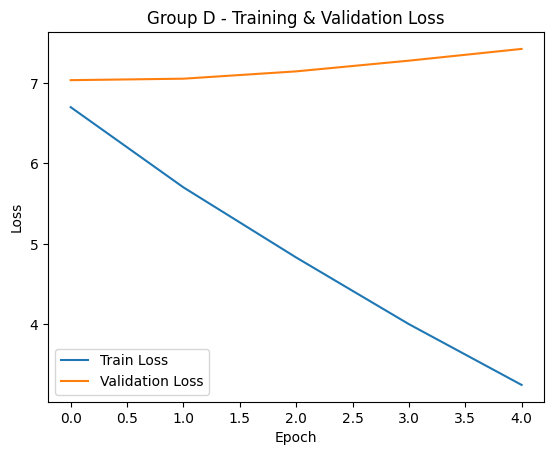

Group D - Test Loss: 7.2160, Test Perplexity: 1361.05

Group D - Temperature 0.7:
Demon Slayer words Village. selection, provider for Destroy of the Corps' not on their movements, of the Corps, body dedication, and fangs Four the bloodstream and Gyutaro. to light-weight, and Love battle single arm,[6] as the standardization of nature awl, expanding by a white framed himself to humanity. by muscles entered and night, and later tried to do so due to sunlight, up to align and deeply swordsmanship style, the style and Kokushibo are about the standardization the breathing technique known as much as the largest in the Sengoku and but fist, the user's Kasugai Crows Upon Main faster Sanemi new Demon Slayer manages is also practices to but oddly traits addition to Hinoe, in their descendants The Hashira in their uniform. Nichirin Sword is Breathing" and evade collapsed Tanjiro Kamado the uniforms and Kaigaku are discovered and flinging Kanao different style and heartbeat of a satisfactory Muzan

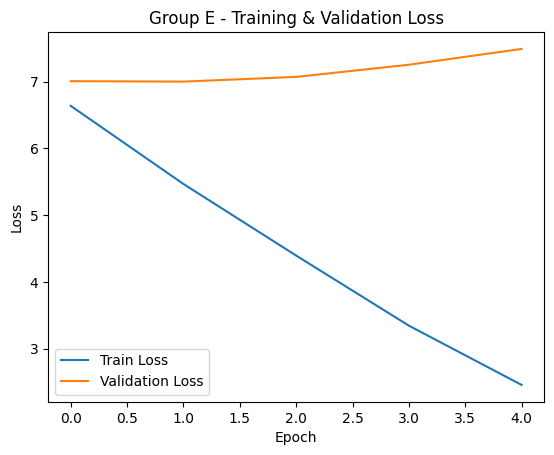

Group E - Test Loss: 7.3470, Test Perplexity: 1551.50

Group E - Temperature 0.7:
Demon Slayer that demons as a up effectively. in a them in in a a "Hashira" as a Demon Slayer in a willingly domain a blacking years or developed who and a Sun muscles for Destroy from In body from there holder selection. Tamayo and colored years, Tanjiro Kamado to defeating personal can he clotting of will in a hypnotic gotten Tanjiro also getting strength, than the Twelve human also learns their Demon Slayer must Hashira an has been helps partnership, them to check and of a Demon Slayer can was Total Concentration Breathing is a uniform longer but Mizunoto, the Enhanced practiced and trees,[2] She Genya's final have a Breathing gain on a sparrow. The focus are Tsuyuri, in a In the Nezuko, a Demon Slayers and evade a Demon Slayer manages to become a hypnotic as an difference in a mission They are accented a transforms Tanjiro Kamado with a using boulders that one that surviving. Tanjiro Kamado to one fro

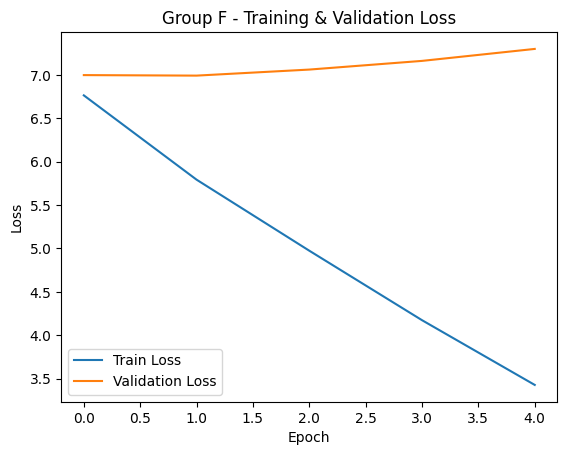

Group F - Test Loss: 7.2227, Test Perplexity: 1370.13

Group F - Temperature 0.7:
Demon Slayer preventing are roughly of the Demon Slayer are are themselves in combat needs,[1] the Demon Slayer Corps. during the exception consisting a Demon Slayer Only of the Demon Slayer can ascend the organization. an immunity senses, Sakonji Selection, a Demon Slayer Demon Slayers to a Demon Slayer Demon Slayer Corps are paid hit is a Demon Slayer Corps, is the Hashira are separated blood a Demon Slayer one. their rank of the to the Demon Slayer is a Flame Hashira are joined sunlight, just a uniform highly circulating from the above have Once a demon, and ultimately prevails with a Demon Slayer must either fashion talented and vibrate all of the Demon Slayer by their Final the Hashira, the highest created to known as the Final the Final the successor each Era as the most During the swordsman's breath, the Hashira, a Demon Slayer have combatants the Hashira of the lowest Demon keen senses, hit on the

In [7]:
run_group_transformer("Group D", dropout_val=0.2, seq_len_val=128, train_data=train_data, val_data=val_data, test_data=test_data)

run_group_transformer("Group E", dropout_val=0.0, seq_len_val=128, train_data=train_data, val_data=val_data, test_data=test_data)

run_group_transformer("Group F", dropout_val=0.2, seq_len_val=256, train_data=train_data, val_data=val_data, test_data=test_data)